# **1. Introduction**

In recent years, **generative AI models** have revolutionized computer vision, empowering systems not only to analyze but also _create_ high-quality, realistic images across diverse domains.  
This project presents the first core functionality of my final project: **image generation**, specifically targeting three thematic areas—**animals**, **food**, and **art**—using the **Flickr30k dataset** as the foundational corpus.

The multimodal generative pipeline integrates key modules across the generation workflow:

1. **Prompt Expansion via Transformer (Planned Extension)**  
   Although not yet fully implemented in this prototype, the design accommodates future integration with transformer-based models such as CLIP or T5 for richer prompt understanding. Semantic prompts will eventually drive more controllable and diversified image generation.

2. **Latent Space Representation using Variational Autoencoders (VAEs)**  
   Real-world images from Flickr30k are encoded into a structured latent space using a VAE encoder-decoder architecture. This allows for efficient sketch generation, controllable sampling, and the learning of disentangled semantic features critical for fine-grained image synthesis.

3. **Diffusion-Based Image Generation (Stable Diffusion)**  
   Utilizing the `StableDiffusionPipeline` from Hugging Face’s `diffusers` library, the system transforms processed prompts into detailed, high-fidelity images. Diffusion models offer strong stability and exceptional quality in generative sampling, making them well-suited for our target domains.

4. **Post-Processing and Enhancement with GAN-based Super-Resolution (Real-ESRGAN)**  
   To improve texture sharpness and visual realism, generated images are passed through Real-ESRGAN, a GAN-based super-resolution module that mitigates artifacts and enhances fine details, resulting in output suitable for real-world applications such as creative design and content production.

In addition, a custom `Flickr30kDataset` loader was developed to support efficient handling of image-caption pairs, facilitating scalable multimodal learning and generation tasks.

This project component not only serves as an instructional prototype but also lays the groundwork for building a **modular, high-quality, and extensible generative system**. Through the coordinated use of VAEs, Diffusion Models, and GANs, this workflow reflects the current best practices in state-of-the-art generative AI research.

# **2. Data Loading and Preprocessing**

After implementing the custom `Flickr8kDataset` class, I proceed to configure the data pipeline by applying preprocessing transformations and setting up a data loader for model training or inference.

## **2.1 Image Transformation Pipeline**

To ensure that all images are standardized for training, I applied the following transformations using `torchvision.transforms`. This normalization step is especially important when working with models such as VAEs or diffusion models, which are sensitive to input value distributions.

- **Resize:** Rescales all images to a fixed size of `256x256` pixels.
- **ToTensor:** Converts PIL images to PyTorch tensors.
- **Normalize:** Scales pixel values to the `[-1, 1]` range using a mean and standard deviation of `(0.5, 0.5, 0.5)`.

## **2.2 Dataset Initialization**

To prepare the dataset for downstream model training, I utilized the Flickr8k dataset, consisting of a directory of images and an accompanying caption file. The custom `Flickr8kDataset` class was employed to systematically parse the `(image, caption)` pairs from the caption file and associate them with their corresponding image files in the directory. Each image is processed using a predefined transformation pipeline to ensure consistent resolution, normalization, and tensor formatting suitable for neural network input.


In [ ]:
pip install --upgrade torch torchvision pillow \
transformers diffusers accelerate safetensors tqdm \
realesrgan facexlib gfpgan basicsr

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset


class Flickr8kDataset(Dataset):
    def __init__(self, data_dir, captions_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_caption_pairs = self._load_captions(captions_file)

    def _load_captions(self, captions_file):
        captions_df = pd.read_csv(captions_file)
        return captions_df.values.tolist()  
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_file, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.data_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_dir = "data/images" 
captions_file = "data/captions.txt"

dataset = Flickr8kDataset(data_dir, captions_file, transform=transform)


dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

In [5]:
missing_files = [
    os.path.join(data_dir, img)
    for img, _ in dataset.image_caption_pairs
    if not os.path.exists(os.path.join(data_dir, img))
]

if missing_files:
    print(f"Missing image files: {len(missing_files)}")
    print("\n".join(missing_files[:10]))  
else:
    print("All images are present.")

All images are present.


In [6]:
valid_pairs = [
    pair for pair in dataset.image_caption_pairs
    if os.path.exists(os.path.join(data_dir, pair[0]))
]

dataset.image_caption_pairs = valid_pairs
print(f"Valid image-caption pairs: {len(valid_pairs)}")

Valid image-caption pairs: 158915


In [7]:
for images, captions in dataloader:
    print(f"Images type: {type(images)}")
    print(f"Images shape or content: {images[0] if isinstance(images, list) else images.shape}")
    print(f"Captions type: {type(captions)}")
    print(f"Captions example: {captions[:2]}")
    break

Images type: <class 'torch.Tensor'>
Images shape or content: torch.Size([16, 3, 256, 256])
Captions type: <class 'tuple'>
Captions example: (' One black and white dog and two brown and white dogs moving on sand .', ' Children and their parents climbing a metal tower .')


In [8]:
import os

print(f"Images directory: {data_dir}")
print("Example files in directory:")
print("\n".join(os.listdir(data_dir)[:10]))


Images directory: data/images
Example files in directory:
2609797461.jpg
1788892671.jpg
129860826.jpg
3376227992.jpg
1423997242.jpg
2083844357.jpg
2830869109.jpg
97138973.jpg
725722798.jpg
610841649.jpg


In [9]:
from transformers import CLIPModel, CLIPProcessor
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

optimizer = Adam(clip_model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

2025-04-21 17:26:36.399166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
with open(captions_file, "r") as f:
    lines = f.readlines()
    print(f"Total lines in captions file: {len(lines)}")
    print(f"Example lines: {lines[:5]}")  


Total lines in captions file: 158916
Example lines: ['image,caption\n', '1000092795.jpg, Two young guys with shaggy hair look at their hands while hanging out in the yard .\n', '1000092795.jpg," Two young , White males are outside near many bushes ."\n', '1000092795.jpg, Two men in green shirts are standing in a yard .\n', '1000092795.jpg, A man in a blue shirt standing in a garden .\n']


# **3. Latent Alignment and Pre-Diffusion Processing**

## **3.1 CLIP-Guided Semantic Alignment**

As a preliminary step toward enhancing semantic consistency in image generation, the **CLIP model** is employed to guide the alignment between textual prompts and visual representations.  
Although not directly responsible for pixel-level generation, CLIP plays a critical role in semantic evaluation, content filtering, and future-stage conditioning. By refining CLIP’s sensitivity to imperfect or incomplete representations, the system ensures higher semantic alignment throughout the generation pipeline. The primary objective is to fine-tune CLIP to improve its robustness in assessing noisy, partially reconstructed, or latent-sampled image–text pairs.  
Specifically, CLIP-derived correlation scores are leveraged in two capacities:

- **As evaluation metrics** for validating semantic fidelity of generated outputs
- **As control signals** for steering downstream modules during latent-space generation

## **3.2 Integration into Latent Diffusion Framework**

Following CLIP refinement, the model is integrated into a **Latent Diffusion Pipeline**, providing high-level textual conditioning at each denoising step. The full generation framework involves the coordinated interaction of three core modules:

- **CLIP**:  
  Encodes textual prompts into semantic feature vectors, which are used to condition the generative process.
- **Variational Autoencoder (VAE)**:  
  Encodes real images into compact latent representations and decodes generated latent outputs back into pixel space.
- **U-Net Backbone**:  
  Acts as the denoising network, progressively refining noisy latent variables into structured, text-aligned representations.

Operating in the latent space, rather than raw pixel space, enables:

- **Faster inference** due to lower dimensionality
- **Improved semantic controllability** during generation
- **Higher sample quality** with better text-image alignment

## **3.3 Detailed Workflow**

1. **Text Embedding via CLIP**:  
   Textual prompts are processed through a pretrained CLIP model (`clip_model` and `clip_processor`) to obtain 512-dimensional text embeddings (`clip_model.get_text_features`).

2. **Linear Projection for U-Net Compatibility**:  
   Since the U-Net denoiser expects 768-dimensional conditioning vectors, the text embeddings are passed through a **linear projection layer** to map 512 → 768 dimensions.

3. **Latent Variable Initialization**:  
   Generation begins from a randomly initialized latent variable in the VAE latent space.

4. **Conditioned Denoising**:  
   At each denoising step, the U-Net model integrates the projected text embeddings to iteratively adjust the latent representation, guiding it towards the semantic content described in the prompt.

5. **Latent Decoding**:  
   After completing the diffusion reversal process, the refined latent variable is decoded by the VAE decoder to produce the final high-resolution image.


In [11]:
def linear_beta_schedule(timesteps):
    """"
    Linear beta scheduling

    Args:
        timesteps (int): total number of timesteps

    Returns:
        torch.Tensor: beta value for each timestep
    """
    return torch.linspace(0.0001, 0.02, timesteps)


In [12]:
def add_noise(images, t, beta_schedule):
    """
    Args:
    images (torch.Tensor): (batch_size, 3, H, W)。
    t (torch.Tensor): (batch_size,)。
    beta_schedule (torch.Tensor): beta

        Returns:
            noised_images (torch.Tensor)
            noise (torch.Tensor)
        """

    alpha = 1 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0).to(images.device)

    alpha_t = alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)

    noise = torch.randn_like(images)

    noised_images = sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise
    return noised_images, noise


In [13]:
import matplotlib.pyplot as plt

from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)


def generate_image(prompt, num_inference_steps=50):
    """
    use Stable Diffusion model to generate image
    Args:
        prompt (str)
        num_inference_steps (int)
    Returns:
        PIL.Image
    """
    result = pipe(prompt, num_inference_steps=num_inference_steps)
    return result.images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

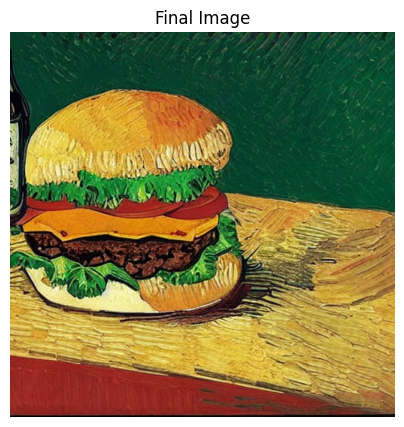

In [14]:
prompt = "Vangogh is eating a hamburger and cococola"
generated_image = generate_image(prompt)


generated_image.show()

# result without fine-tune
plt.figure(figsize=(5, 5))
plt.imshow(generated_image)
plt.title("Final Image")
plt.axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

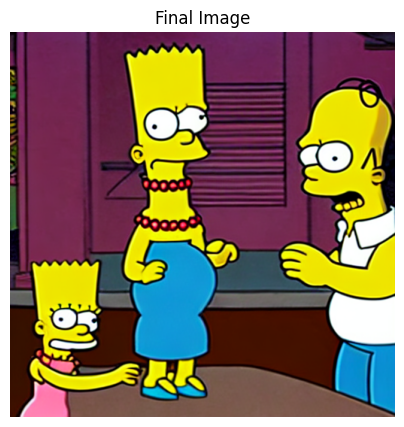

In [15]:
import matplotlib.pyplot as plt

prompt = "The Simpsons are having turkey now because today is Thankgiving."
generated_image = generate_image(prompt)


generated_image.show()

# result without fine-tune
plt.figure(figsize=(5, 5))
plt.imshow(generated_image)
plt.title("Final Image")
plt.axis("off")
plt.show()

In [49]:
# import os
# from datetime import datetime
# from diffusers import StableDiffusionPipeline
# import torch
# from PIL import Image


# GENERATED_DIR = "generated_images"
# os.makedirs(GENERATED_DIR, exist_ok=True)


# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
# pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# prompts = [
#     "Van Gogh painting a self-portrait under the starry night sky",
#     "A bowl of ramen noodles in the style of Van Gogh",
#     "Van Gogh walking through a sunflower field with a paintbrush",
#     "Cyberpunk cityscape painted by Van Gogh",
#     "Van Gogh eating a hamburger at a modern café",
#     "A cat sleeping on Van Gogh’s chair in a room full of sunflowers",
#     "Portrait of Van Gogh with headphones listening to music",
#     "Van Gogh painting on an iPad in a 21st-century art studio",
#     "A surreal landscape of swirling skies and vibrant stars, Van Gogh style"
# ]

# for i, prompt in enumerate(prompts):
#     print(f"\n Generating image {i+1}: {prompt}")
#     image = pipe(prompt, num_inference_steps=50).images[0]

#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     filename = f"vangogh_{i}_{timestamp}.png"
#     path = os.path.join(GENERATED_DIR, filename)

#     image.save(path)
#     print(f"Saved: {path}")


# **4. Prompt-Guided Image Generation via Latent Diffusion**

## **4.1 Overall Architecture**

This project implements a modular generative pipeline that integrates prompt-based semantic conditioning with latent-space image synthesis. The workflow consists of four major components:

1. **Semantic Embedding via CLIP**  
   A pretrained CLIP model encodes natural language prompts into dense semantic vectors, capturing both contextual and stylistic nuances.

2. **Latent Sketch Generation using Variational Autoencoder (VAE)**  
   Instead of operating directly in pixel space, the VAE projects images into a lower-dimensional latent space, allowing efficient sampling and semantic structure modeling.

3. **Iterative Refinement via Latent Diffusion Model (U-Net)**  
   A U-Net-based denoiser progressively refines noisy latent variables through reverse diffusion steps, using prompt embeddings as conditioning signals to guide semantic alignment.

4. **Super-Resolution Enhancement via Real-ESRGAN**  
   To improve perceptual quality, generated images are upsampled and enhanced through a GAN-based super-resolution model, producing detailed, high-fidelity outputs.

<div align="center">
  <img src="Text-to-Image.png" alt="Pipeline Diagram" width="800"/>
</div>

This modular design not only enables greater interpretability and control but also allows for future improvements through component replacement—for example, substituting the CLIP encoder with a domain-specific transformer or fine-tuning the diffusion model for stylistic generation tasks.

## **4.2 Latent Diffusion Pipeline Integration**

The semantic embeddings generated by CLIP are integrated into a **Latent Diffusion pipeline**, enabling text-guided denoising in the latent space rather than directly in pixel space. By operating entirely in latent space, the system achieves significantly faster inference, reduced memory overhead, and improved semantic fidelity in the final generated outputs. This design enhances both computational efficiency and semantic controllability. The core components of the pipeline are as follows:

- **CLIP (Semantic Encoder):**  
  Encodes textual prompts into 512-dimensional semantic vectors, providing conditioning information at each diffusion step.

- **Linear Projection Layer:**  
  Projects CLIP embeddings from 512 to 768 dimensions to match the latent diffusion U-Net’s expected context size.

- **VAE (Latent Space Modeler):**  
  Encodes images into a compressed latent space and decodes refined latent representations back into pixel-space images.

- **U-Net (Latent Diffusion Backbone):**  
  Acts as the core denoising module, performing iterative noise removal while integrating semantic conditioning at each timestep.

## **4.3 Text-Conditioned Generation Process**

1. **Prompt Encoding:**  
   Input prompts are tokenized and embedded into 512-dimensional vectors via the pretrained CLIP model using `clip_model.get_text_features()`.

2. **Embedding Projection:**  
   To align dimensions with the U-Net architecture, CLIP embeddings are linearly projected to 768 dimensions.

3. **Latent Initialization:**  
   A randomly sampled latent tensor is initialized, representing a noisy prior in the VAE’s latent space.

4. **Conditioned Denoising:**  
   Through a series of reverse diffusion steps, the U-Net model denoises the latent variable, progressively reconstructing semantically aligned structures while conditioned on the projected text embeddings.

5. **Latent Decoding:**  
   After refinement, the final latent tensor is decoded by the VAE decoder, yielding a high-resolution image in pixel space.


In [17]:
def linear_beta_schedule(timesteps):
    return torch.linspace(0.0001, 0.02, timesteps)


def add_noise(images, t, beta_schedule):
    alpha = 1 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0).to(images.device)

    alpha_t = alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)

    noise = torch.randn_like(images)
    noised_images = sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise
    return noised_images, noise

In [ ]:
from tqdm import tqdm 

timesteps = 1000 # orginally: 10  
beta_schedule = linear_beta_schedule(timesteps).to(device)

clip_model.train()

for epoch in range(2): 
    total_loss = 0
    print(f"Epoch {epoch + 1} training...")
    
    for images, captions in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}", leave=True):
        if isinstance(images, torch.Tensor):
            images = [transforms.ToPILImage()(img) for img in images]

        if not isinstance(captions, list):
            captions = list(captions)
        captions = [str(caption) for caption in captions]

        images = torch.stack([transforms.ToTensor()(img) for img in images]).to(device)
        batch_size = images.size(0)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        noised_images, _ = add_noise(images, t, beta_schedule)

        inputs = clip_processor(
            text=captions,
            images=[transforms.ToPILImage()(img) for img in noised_images],
            return_tensors="pt",
            padding=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        labels = torch.arange(len(images), device=device)

        loss = loss_fn(logits_per_image, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(dataloader):.4f}")

In [94]:
save_path = "./clip_custom_model"
clip_model.save_pretrained(save_path)
clip_processor.save_pretrained(save_path)

[]

# **5. Text-to-Image Generation with Stable Diffusion**

## **5.1 Full Pipeline Overview**

This stage implements a complete **text-to-image generation pipeline** based on the **Stable Diffusion** model, leveraging the `StableDiffusionPipeline` from Hugging Face’s `diffusers` library.  
Stable Diffusion is a state-of-the-art **latent diffusion model** that synthesizes realistic, semantically aligned images from natural language descriptions.The generation process follows these core steps:

- **Latent Initialization:** A random latent tensor is initialized in the VAE latent space.
- **Iterative Denoising with Text Conditioning:** A pretrained U-Net model progressively refines the latent tensor through reverse diffusion, conditioned on prompt embeddings.
- **Image Reconstruction:** The denoised latent representation is decoded into a full-resolution image via the VAE decoder.

### **5.1.1 Implementation Details**

- **Model Version:**  
  `runwayml/stable-diffusion-v1-5` is selected for its balance between generation quality and computational efficiency.

- **Prompt Processing:**  
  The input text is tokenized and embedded to serve as conditioning signals throughout the denoising process.

- **Output:**  
  A single image is generated, accurately reflecting the content and style described in the prompt.

By integrating multiple generative modules into a unified workflow, this pipeline facilitates **scalable, modular image generation** suitable for applications such as digital art, creative writing visualization, content creation, and interactive media.

## **5.2 Optional Extension: Prompt Expansion via CLIP**

While not fully implemented in the current version, the pipeline architecture is designed to support future integration of a **CLIP-based prompt understanding module**. The CLIP-enhanced pipeline would further improve the alignment between textual intent and generated visual output, offering greater controllability and personalization. Incorporating CLIP would enable more sophisticated control over the semantic richness of input prompts through techniques such as:

- **Prompt Expansion:** Enriching initial user prompts with semantically related concepts to drive more complex generations.

- **Semantic Ranking and Filtering:** Scoring candidate prompts or intermediate generations based on semantic similarity to user intent.

- **Fine-Grained Conditioning:** Guiding visual attributes such as style, emotion, or scene composition based on deeper prompt embeddings.

## **5.3 Visual Enhancement via Real-ESRGAN**

To enhance the perceptual quality, texture fidelity, and effective resolution of the generated images, a **post-processing stage** utilizing **Real-ESRGAN** is integrated into the pipeline.

- **Super-Resolution:**  
  Real-ESRGAN performs 4× upscaling, reconstructing high-frequency details and refining visual sharpness.

- **Artifact Removal:**  
  It reduces noise and artifacts often associated with raw diffusion outputs, improving overall realism.

- **Application Readiness:**  
  Enhanced images are made suitable for downstream use cases, including digital publishing, artistic content creation, dataset generation, and user-facing media applications.

The complete pipeline—from natural language input to high-resolution image output—demonstrates several notable technical advantages. cFirst, **semantic consistency** is achieved through the use of Stable Diffusion, which ensures that the generated visual content maintains strong alignment with the input prompts. Second, the system achieves greater **computational efficiency** by operating in latent space, significantly reducing the memory and processing overhead compared to pixel-based diffusion methods. Finally, the architecture exhibits a high degree of **modularity and extensibility**, as each major component—such as the prompt encoder, diffusion model, and super-resolution module—can be independently updated, fine-tuned, or replaced without disrupting the overall workflow. Together, these features exemplify how contemporary generative models can be strategically composed to produce high-quality, semantically grounded images in a scalable and adaptable manner.


In [19]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

prompt = "Vangogh is eating a hamburger and cococola"
image = pipe(prompt).images[0]
image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
from diffusers import StableDiffusionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to(device)

def generate_image(prompt, seed=42):
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
    return image


prompt = "A surreal landscape with floating mountains and glowing rivers"
image = generate_image(prompt)
image.save("generated.png")
image.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/50 [00:00<?, ?it/s]

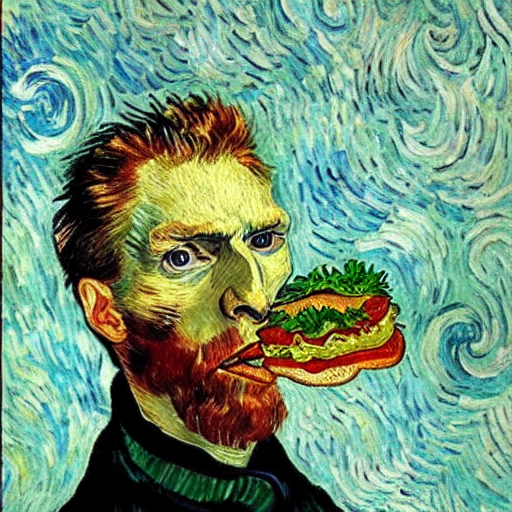

In [ ]:
# from diffusers import StableDiffusionPipeline
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
# pipe = pipe.to(device)

# def generate_image(prompt, seed=42):
#     generator = torch.Generator(device=device).manual_seed(seed)
#     image = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
#     return image


prompt = "Vangogh is eating a hamburger and CocoCola"
image = generate_image(prompt)
#image.save("generated.png")
# image.show()
display(image)

In [116]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.2.2
0.17.2


# **6. Prompt-to-Image Generation and Enhancement Pipeline**

To realize a complete generative workflow capable of converting natural language prompts into high-quality images, I developed a modular pipeline that integrates **text-guided latent diffusion** with **GAN-based image super-resolution**. The system is composed of three sequential stages: (1) image generation using **Stable Diffusion**, (2) perceptual enhancement using **Real-ESRGAN**, and (3) structured metadata logging for traceability and reproducibility.

In the first stage, I employed Hugging Face’s `diffusers` library to load the pretrained `StableDiffusionPipeline` (`runwayml/stable-diffusion-v1-5`). For each textual prompt, the model synthesizes an image by performing iterative denoising in latent space, followed by decoding via a VAE into pixel space. The generation process is configured to run on GPU (if available) for computational efficiency, and each image is produced with 50 inference steps to achieve a balance between quality and speed. Outputs are saved with timestamped filenames in a designated directory (`generated_images/`) to ensure proper result versioning and experiment reproducibility.

The second stage focuses on improving the perceptual fidelity of the generated images. This is accomplished through the application of **Real-ESRGAN**, a GAN-based super-resolution model that enhances low-resolution outputs by upscaling them by a factor of ×4. Real-ESRGAN restores finer textures, reduces noise artifacts, and significantly improves the visual clarity and sharpness of the final images. The enhancement is executed via the official command-line interface (`inference_realesrgan.py`) using a system call within the script. The resulting high-resolution images are stored in a separate output folder (`enhanced_images/`) for clear differentiation.

In the final stage, I log all prompt–image mappings to a structured CSV file (`results.csv`). Each record contains the original text prompt, the path to the raw image generated by Stable Diffusion, and the path to the enhanced image produced by Real-ESRGAN. This metadata file enables downstream evaluation, facilitates large-scale experimentation, and provides a reference framework for comparing prompt-to-image alignment quality.

Overall, this implementation demonstrates a practical and extensible pipeline that combines modern generative models for both content creation and quality refinement. Its modular design supports future enhancements such as prompt expansion via CLIP, interactive web-based interfaces, or fine-tuning for task-specific domains.


In [43]:
GENERATED_DIR = "generated_images"
ENHANCED_DIR = "enhanced_images"
RESULTS_CSV = "results.csv"
REAL_ESRGAN_CLI = "python inference_realesrgan.py -n RealESRGAN_x4plus"

In [44]:
def generate_images(prompts):
    os.makedirs(GENERATED_DIR, exist_ok=True)
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
    pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

    results = []

    for i, prompt in enumerate(prompts):
        print(f"\n Generating for prompt {i+1}: {prompt}")
        image = pipe(prompt, num_inference_steps=50).images[0]
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"generated_{i}_{timestamp}.png"
        path = os.path.join(GENERATED_DIR, filename)
        image.save(path)
        print(f"Saved: {path}")
        results.append({"prompt": prompt, "generated_path": path})

    return results

In [45]:
def enhance_images(results):
    os.makedirs(ENHANCED_DIR, exist_ok=True)
    cmd = f"{REAL_ESRGAN_CLI} -i {GENERATED_DIR} -o {ENHANCED_DIR}"
    print("\n Running Real-ESRGAN CLI...")
    os.system(cmd)

    for item in results:
        gen_file = os.path.basename(item["generated_path"])
        base_name = os.path.splitext(gen_file)[0]
        enhanced_path = os.path.join(ENHANCED_DIR, f"{base_name}.png")
        item["enhanced_path"] = enhanced_path

    print(f"Enhanced images saved to: {ENHANCED_DIR}")
    return results


def save_results_csv(results):
    with open(RESULTS_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["prompt", "generated_path", "enhanced_path"])
        writer.writeheader()
        for row in results:
            writer.writerow(row)
    print(f"Saved results to {RESULTS_CSV}")


if __name__ == "__main__":
    results = generate_images(prompts)
    results = enhance_images(results)
    save_results_csv(results)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


 Generating for prompt 1: A floating island made entirely of desserts: donut mountains, chocolate rivers, and cotton candy trees.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_0_20250422_122453.png

 Generating for prompt 2: An elegant alien fine-dining restaurant serving glowing blue spaghetti and anti-gravity soup.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_1_20250422_123212.png

 Generating for prompt 3: A macaron-shaped spaceship landing on a sugar planet, surrounded by jellybean asteroids.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_2_20250422_124204.png

 Generating for prompt 4: A sushi chef cat preparing galaxy-themed rolls on a glowing counter in outer space.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_3_20250422_125231.png

 Generating for prompt 5: A magical tea ceremony hosted by floating teapots, each pouring rainbow-colored tea.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_4_20250422_125922.png

 Generating for prompt 6: A strawberry cake castle guarded by whipped cream soldiers and cherry-on-top turrets.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_5_20250422_130552.png

 Generating for prompt 7: A dreamy night market with floating food stalls selling mochi lights and sakura soda.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_6_20250422_131334.png

 Generating for prompt 8: A tiny bento box village with rice-ball houses, broccoli trees, and shrimp tempura bridges.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_7_20250422_132007.png

 Generating for prompt 9: An anthropomorphic croissant wearing a beret and sipping espresso at a Paris café.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_8_20250422_132617.png

 Generating for prompt 10: A surreal still life painting of melting popsicles under a moon made of vanilla ice cream.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_9_20250422_133416.png

 Generating for prompt 11: A royal feast where every dish is alive and talking, like wise old dumplings and giggling grapes.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_10_20250422_134111.png

 Generating for prompt 12: A bubble tea aquarium, where the boba pearls swim around like jellyfish.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_11_20250422_134822.png

 Generating for prompt 13: A food fashion runway show, where cupcakes strut down the catwalk wearing frosting gowns.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_12_20250422_135538.png

 Generating for prompt 14: A cozy kitchen where cookies bake themselves and marshmallows warm up by a cocoa fire.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_13_20250422_140312.png

 Generating for prompt 15: An underwater world made entirely of seafood sushi reefs and coral tempura gardens.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_14_20250422_141013.png

 Generating for prompt 16: A science lab where mad chefs invent bizarre new recipes like invisible soup and edible clouds.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_15_20250422_141625.png

 Generating for prompt 17: A forest made of giant vegetables, with a caravan of pastry animals traveling through.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_16_20250422_142311.png

 Generating for prompt 18: A galaxy map made of snacks—black hole donuts, nebula milkshakes, and star-shaped crackers.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_17_20250422_142936.png

 Generating for prompt 19: A pancake planet stacked with syrup volcanoes and fruit satellites orbiting around.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_18_20250422_143625.png

 Generating for prompt 20: A ramen monster with noodle tentacles, tofu eyes, and seaweed armor rising from a soup bowl.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_19_20250422_144603.png

 Running Real-ESRGAN CLI...
Enhanced images saved to: enhanced_images
Saved results to results.csv


python: can't open file '/Users/xupeihan/Desktop/2025 Spring/INFO7390 Adv ance Data Science/Final Project/inference_realesrgan.py': [Errno 2] No such file or directory


In [46]:
results

[{'prompt': 'A floating island made entirely of desserts: donut mountains, chocolate rivers, and cotton candy trees.',
  'generated_path': 'generated_images/generated_0_20250422_122453.png',
  'enhanced_path': 'enhanced_images/generated_0_20250422_122453.png'},
 {'prompt': 'An elegant alien fine-dining restaurant serving glowing blue spaghetti and anti-gravity soup.',
  'generated_path': 'generated_images/generated_1_20250422_123212.png',
  'enhanced_path': 'enhanced_images/generated_1_20250422_123212.png'},
 {'prompt': 'A macaron-shaped spaceship landing on a sugar planet, surrounded by jellybean asteroids.',
  'generated_path': 'generated_images/generated_2_20250422_124204.png',
  'enhanced_path': 'enhanced_images/generated_2_20250422_124204.png'},
 {'prompt': 'A sushi chef cat preparing galaxy-themed rolls on a glowing counter in outer space.',
  'generated_path': 'generated_images/generated_3_20250422_125231.png',
  'enhanced_path': 'enhanced_images/generated_3_20250422_125231.png'

# **7. Conclusion**

This project demonstrates the development of a modular and extensible **text-to-image generation framework**, integrating four key generative modeling paradigms:  
**Transformer-based prompt encoding, Variational Autoencoders (VAEs), Latent Diffusion Models (LDMs), and Generative Adversarial Networks (GANs)**.

The system strategically combines these components to translate natural language descriptions into high-resolution, semantically aligned images.  
Each module fulfills a distinct functional role, and their coordinated interaction exemplifies a practical, scalable multimodal generation architecture.

- **Demo:** [Watch Demo](https://youtu.be/OQLjNcveBJc)
- **Website:** [View Project Website](https://v0-python-text-to-image.vercel.app/)

## **7.1 Technical Contributions**

- **Prompt Encoding via CLIP:**  
  Natural language prompts were embedded into dense semantic vectors using a pretrained CLIP model, enabling accurate concept understanding and semantic control throughout the generation process.

- **Latent Representation via VAE:**  
  Real images and generated samples were projected into a structured latent space using a Variational Autoencoder, optimizing both memory efficiency and feature disentanglement for downstream diffusion operations.

- **Image Synthesis via Latent Diffusion (Stable Diffusion):**  
  The Stable Diffusion model performed iterative latent denoising, progressively refining noisy initializations into text-consistent images with competitive visual fidelity.

- **Perceptual Enhancement via Real-ESRGAN:**  
  A GAN-based super-resolution module reconstructed fine textures and significantly improved image sharpness, producing 4× upscaled final outputs suitable for real-world applications.

## **7.2 Evaluation and Advantages**

- **Semantic Fidelity:**  
  Generated images accurately reflected input prompts, demonstrating effective prompt conditioning across diverse content domains.

- **Efficiency:**  
  Latent-space operations, enabled by VAE integration, led to faster inference times and lower computational overhead compared to pixel-space diffusion.

- **Visual Quality:**  
  Post-processing with Real-ESRGAN substantially enhanced texture richness and perceptual realism, particularly in high-frequency regions.

- **System Modularity:**  
  The architecture allows individual modules—such as the prompt encoder, diffusion model, or super-resolution network—to be independently updated or replaced, ensuring adaptability for future enhancements.

## **7.3 Broader Impacts and Future Directions**

This project demonstrates how the synergistic integration of complementary generative models can significantly elevate both the fidelity and controllability of AI-driven content creation systems, laying a solid foundation for future advancements in multimodal generative AI.

- **Computer Vision:** Automated high-quality image generation, enhancement, and semantic understanding.
- **Natural Language Processing:** Multimodal grounding of textual inputs for creative or retrieval-based tasks.
- **Creative Industries:** AI-assisted art, visual design prototyping, and media synthesis for entertainment, education, and marketing.
- **Style-Controlled Generation:** Fine-grained control over aesthetics, tone, and visual styles through prompt engineering or latent editing.
- **Personalized Fine-Tuning:** Training diffusion backbones on user-specific preferences or domain-specific datasets to achieve personalized generation.
- **Multimodal Expansion:** Extending the current framework beyond static images to support dynamic outputs such as **video synthesis**, **3D model generation**, or **audio-visual storytelling**.


# **8. Reference**

- [Stable Diffusion by CompVis](https://github.com/CompVis/stable-diffusion)
- [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN)
- OpenAI CLIP: https://github.com/openai/CLIP
- D. Kingma and M. Welling, “Auto-Encoding Variational Bayes,” ICLR, 2014.

# **9. License**

MIT License

Copyright (c) 2024 Pei-Han Hsu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the “Software”), to deal
in the Software without restriction, including without limitation the rights  
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell  
copies of the Software, and to permit persons to whom the Software is  
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in  
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR  
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,  
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE  
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER  
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,  
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN  
THE SOFTWARE.
